In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import linear_model
from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [40]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

In [41]:
def simulate_genotype_and_phenotype(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    G = np.append(G, Y_n, axis=1)
    return G, loci


In [61]:
def shap_LR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    lassoReg = linear_model.Lasso(alpha=.1)
    lassoReg.fit(x_train, y_train)
    explainer = shap.KernelExplainer(lassoReg.predict, shap.kmeans(x_train,100))
    shap_values = explainer.shap_values(x_test)
    return shap_values, x_train

In [62]:
#for RFR
def mean_shap_values(shap_values):
    
    shap_values = np.array(shap_values)
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
    return avg_shap

In [63]:
def max_mean_feature(shap_values):
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-2:][::-1]
    loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices[0], loci1

In [64]:
def shap_acc_LR_var(samples_n, loci_m, var_g, number_trials):
    shap_values_SNP = []
    counter = 0
    var_e_list = [0,0.2,0.4,0.6,0.8]
    while counter != number_trials:
        var_e = random.choice(var_e_list)
        G, loci = simulate_genotype_and_phenotype(samples_n,loci_m, var_g , var_e)
        shap_values_holder, x_train = shap_LR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int

In [58]:
# var_g = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
var_g = [0]

var_e_list = [0,0.2,0.4,0.6,0.8]
number_trials = 80
samples = 1000
loci = 20
precent_list =  []
for var_g in var_g:
    percent,confidence_int = shap_acc_LR_var(samples, loci,var_g,number_trials)
    precent_list.append(percent)
        
        

In [50]:
# with open('/u/home/k/kevindel/project-ngarud/Kevin_BIG_Summer_Code/lasso_LR_oneloci/lasso_LR_SHAP_oneloci_0', 'wb') as fp:
#     pickle.dump(precent_list, fp)

[0.0, 0.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

In [65]:
lasso_LR_list = []
for i in range(0,10): 
    with open ('/Users/kevin/Desktop/UCLA_BIG_Code/Code_Data/Lasso_LR_OneLoci/lasso_list_'+str(i), 'rb') as fp:
        corr2list = pickle.load(fp)
    lasso_LR_list.append(corr2list)

In [105]:
len(lasso_LR_list)

10

In [102]:
lasso_LR_list[0]

[2.0, 4.0, 16.0, 2.0, 0.0]

In [103]:
e_vals = [0,.2,.4,.6,.8]
g_vals = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

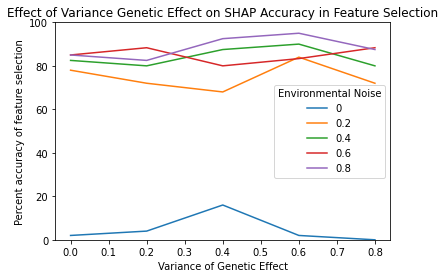

In [106]:
for x in range(0, len(lasso_LR_list[0])):
#         e_vals[x] = str(round(e_vals[x], 2))
        plt.plot(e_vals, lasso_LR_list[x], label = e_vals[x]) 
    
plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
plt.xlabel('Variance of Genetic Effect')
plt.ylabel('Percent accuracy of feature selection')
plt.ylim([0,100])
plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
plt.legend(title = 'Environmental Noise')
